In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import io, img_as_float
from skimage.filters import sobel
from scipy.stats import skew, kurtosis, entropy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
def load_gray(img_path, size=(512, 512)):
    img = io.imread(img_path, as_gray=True)
    img = img_as_float(img)
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

In [3]:
def extract_features(img, file_path, scanner_id="unknown"):
    h, w = img.shape
    aspect_ratio = w / h
    file_size_kb = os.path.getsize(file_path) / 1024  # in KB
    pixels = img.flatten()

    # Basic statistics
    mean_intensity = np.mean(pixels)
    std_intensity = np.std(pixels)
    skewness = skew(pixels)
    kurt_val = kurtosis(pixels)
    ent = entropy(np.histogram(pixels, bins=256, range=(0, 1))[0] + 1e-6)

    # Edge features
    edges = sobel(img)
    edge_density = np.mean(edges > 0.1)

    return {
        "file_name": os.path.basename(file_path),
        "class_label": scanner_id,
        "width": w,
        "height": h,
        "aspect_ratio": aspect_ratio,
        "file_size_kb": file_size_kb,
        "mean_intensity": mean_intensity,
        "std_intensity": std_intensity,
        "skewness": skewness,
        "kurtosis": kurt_val,
        "entropy": ent,
        "edge_density": edge_density
    }

In [4]:
columns = [
    "class_label", "file_size_kb",
    "mean_intensity", "std_intensity", "skewness", "kurtosis",
    "entropy", "edge_density"
]

In [5]:
metadata = pd.DataFrame(columns=columns)

In [6]:
def process_image_and_append(df, img_path, scanner_id="unknown"):
    img = load_gray(img_path)
    features = extract_features(img, img_path, scanner_id)
    df.loc[len(df)] = features
    return df

In [7]:
dataset_dir = r"C:\Users\diksh\Downloads\trace finder dataset"

In [9]:
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('.tif', '.jpg', '.png')):
            img_path = os.path.join(root, file)
            relative_path = os.path.relpath(img_path, dataset_dir)
            scanner_id = relative_path.split(os.sep)[0]
            
            print(f"Processing: {file} | Scanner ID: {scanner_id}")
            metadata = process_image_and_append(metadata, img_path, scanner_id)

Processing: s1_1.tif | Scanner ID: Canon120-1
Processing: s1_10.tif | Scanner ID: Canon120-1
Processing: s1_11.tif | Scanner ID: Canon120-1
Processing: s1_13.tif | Scanner ID: Canon120-1
Processing: s1_15.tif | Scanner ID: Canon120-1
Processing: s1_16.tif | Scanner ID: Canon120-1
Processing: s1_17.tif | Scanner ID: Canon120-1
Processing: s1_18.tif | Scanner ID: Canon120-1
Processing: s1_19.tif | Scanner ID: Canon120-1
Processing: s1_2.tif | Scanner ID: Canon120-1
Processing: s1_20.tif | Scanner ID: Canon120-1
Processing: s1_21.tif | Scanner ID: Canon120-1
Processing: s1_22.tif | Scanner ID: Canon120-1
Processing: s1_23.tif | Scanner ID: Canon120-1
Processing: s1_24.tif | Scanner ID: Canon120-1
Processing: s1_25.tif | Scanner ID: Canon120-1
Processing: s1_26.tif | Scanner ID: Canon120-1
Processing: s1_27.tif | Scanner ID: Canon120-1
Processing: s1_28.tif | Scanner ID: Canon120-1
Processing: s1_29.tif | Scanner ID: Canon120-1
Processing: s1_3.tif | Scanner ID: Canon120-1
Processing: s1_3

In [10]:
metadata.info()
display(metadata.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2088 entries, 0 to 2087
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   class_label     2088 non-null   object 
 1   file_size_kb    2088 non-null   float64
 2   mean_intensity  2088 non-null   float64
 3   std_intensity   2088 non-null   float64
 4   skewness        2088 non-null   float64
 5   kurtosis        2088 non-null   float64
 6   entropy         2088 non-null   float64
 7   edge_density    2088 non-null   float64
dtypes: float64(7), object(1)
memory usage: 146.8+ KB


,class_label,file_size_kb,mean_intensity,std_intensity,skewness,kurtosis,entropy,edge_density
0,Canon120-1,6366.801758,0.972213,0.104171,-4.147706,16.985540,0.879780,0.128208
1,Canon120-1,6366.801758,0.969917,0.109190,-4.046214,16.014230,0.883227,0.097931
2,Canon120-1,6366.801758,0.973881,0.087714,-4.209022,19.795997,1.044780,0.134338
3,Canon120-1,6366.801758,0.980218,0.077358,-4.790764,25.914771,0.781967,0.109833
4,Canon120-1,6366.801758,0.977808,0.076888,-4.214462,18.679896,1.058874,0.107262


In [11]:
metadata = metadata.dropna()

In [13]:
X = metadata[["file_size_kb", "mean_intensity", "std_intensity",
              "skewness", "kurtosis", "entropy", "edge_density"]]
y = metadata["class_label"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [19]:
y_pred = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n SVM Model Accuracy: {accuracy * 100:.2f}%")


 SVM Model Accuracy: 29.19%


In [20]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  Canon120-1       0.24      0.15      0.19        33
  Canon120-2       0.14      0.38      0.20        45
    Canon220       0.00      0.00      0.00        40
 Canon9000-1       0.00      0.00      0.00        40
 Canon9000-2       0.15      0.20      0.17        40
 EpsonV370-1       0.35      0.30      0.32        40
 EpsonV370-2       0.38      0.42      0.40        40
  EpsonV39-1       0.10      0.10      0.10        40
  EpsonV39-2       0.00      0.00      0.00        20
   EpsonV550       0.44      0.47      0.46        40
          HP       0.95      1.00      0.98        40

    accuracy                           0.29       418
   macro avg       0.25      0.28      0.26       418
weighted avg       0.26      0.29      0.27       418



c:\Users\diksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\diksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\diksh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


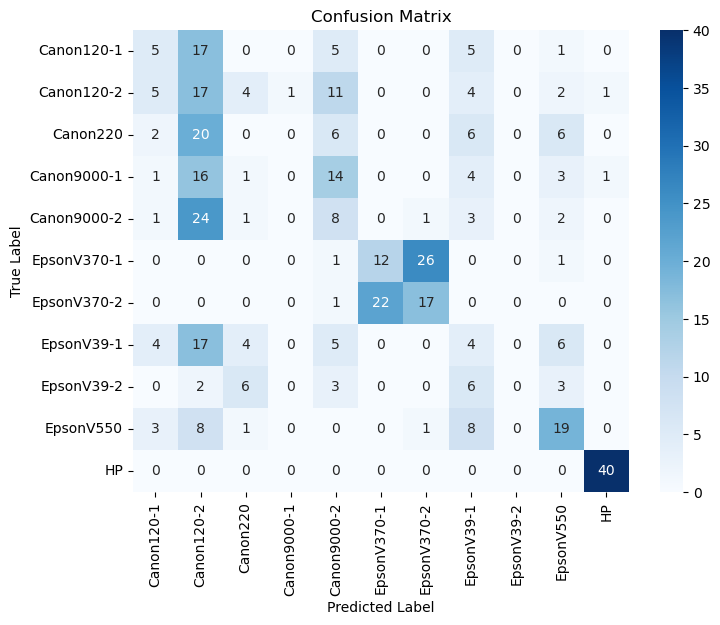

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()